# 116th Congress Data

This notebook is meant to call, clean, and examine data from the 2018 election, to produce a viable metric correlating PVI and electoral success.

It feeds into a larger project about fairness in redistricting; for instance, if an R+15 district is unattainable for a Democrat to win, then the district can be wholly classified as "safe," and should be bucketed with R+30 district.

The nuance enters in the margins. How safe is an R+6 district for instance? Can we quantify a district moving from R+3 to R+6 as a significant bias against Democrats? By cleaning this dataset, and others like it, we can determine the predictive power of PVI in each district, and use those probabilities later to assess redistricting fairness.

## Upload Data from Cook

The Cook Political Report contains data from the 2018 election results; it appears to be a version from around March or April 2019, given the vacancy of PA-12, NC-3, and NC-9

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
pvi_116_og = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/raw_data/pvi_116.csv")

In [3]:
#insert Greg Murphy as the seat has no data associated with it
pvi_116_og = pvi_116_og.replace("()","Greg Murphy (R)")

## Clean and Organize State Data

In [4]:
#call the dataset into a new variable as not to disrupt the original pull
pvi_116 = pvi_116_og
#create a column of just two letter state codes
pvi_116["ST"] =  pvi_116['Dist'].str.split('-').str[0]
#create a district number and ditch the lead zero
pvi_116["district"] =  pvi_116['Dist'].str.split('-').str[1]
pvi_116["district"] = pvi_116["district"].str.lstrip("0")
#create the universal ST# variable that will appear in all datasets
pvi_116["ST#"] = pvi_116["ST"] + pvi_116["district"]

In [5]:
#split out pvi by party and weight
#first eliminate even values
pvi_116["PVI"] = pvi_116["PVI"].str.replace("EVEN","R+0")
#pull the party lean from the pvi
pvi_116["pvi_party"] = pvi_116.PVI.str[0]
#pull the partisan value from the pvi
pvi_116['partisan_weight'] = pvi_116['PVI'].str.split('+').str[1]
#check results
print(pvi_116.head(n=1))
print(pvi_116["pvi_party"].unique())

    Dist          Incumbent   PVI  Clinton %  Trump %  Obama %  Romney %  ST  \
0  AL-01  Bradley Byrne (R)  R+15       33.8     63.0     37.3      61.7  AL   

  district  ST# pvi_party partisan_weight  
0        1  AL1         R              15  
['R' 'D']


In [6]:
#add constants for later aggregation
pvi_116["year"] = 2018
pvi_116["congress"] = 116

In [7]:
#create a variable that is negative when the party is democratic
pvi_116["neg"] = pvi_116['pvi_party'].str.replace('D','-')
pvi_116["neg"] = pvi_116["neg"].str.replace('R','')
#ensure partisan weight has a negative value for democratic leaning and a positive value for Republican leaning
pvi_116['partisan_weight'] = pvi_116["neg"] + pvi_116['partisan_weight']
#ensure values are integers
pvi_116['partisan_weight'] = pvi_116['partisan_weight'].astype(int)

In [8]:
pvi_116["metric"] = ((pvi_116['partisan_weight'] / 2) + 50) / 100
pvi_116.head(n=7)

,Dist,Incumbent,PVI,Clinton %,Trump %,Obama %,Romney %,ST,district,ST#,pvi_party,partisan_weight,year,congress,neg,metric
0,AL-01,Bradley Byrne (R),R+15,33.8,63.0,37.3,61.7,AL,1,AL1,R,15,2018,116,,0.575
1,AL-02,Martha Roby (R),R+16,32.8,64.5,36.4,62.8,AL,2,AL2,R,16,2018,116,,0.580
2,AL-03,Mike Rogers (R),R+16,31.9,64.8,36.7,62.2,AL,3,AL3,R,16,2018,116,,0.580
3,AL-04,Robert Aderholt (R),R+30,17.3,79.8,23.9,74.7,AL,4,AL4,R,30,2018,116,,0.650
4,AL-05,Mo Brooks (R),R+18,30.9,63.7,34.8,63.7,AL,5,AL5,R,18,2018,116,,0.590
5,AL-06,Gary Palmer (R),R+26,25.8,69.6,24.6,74.3,AL,6,AL6,R,26,2018,116,,0.630
6,AL-07,Terri Sewell (D),D+20,69.5,28.3,72.5,27.0,AL,7,AL7,D,-20,2018,116,-,0.400


In [9]:
import numpy as np
import plotnine as p9
from plotnine import ggplot, aes, facet_grid, labs, geom_point, geom_smooth
from sklearn.linear_model import LinearRegression as lm
import warnings
warnings.filterwarnings('ignore')

In [10]:
#create a variable that shows the current occupant of the congressional seat
pvi_116["seat"] = pvi_116.Incumbent.str[-2]
#make a dummy
pvi_116["is_GOP"] = pvi_116["seat"].replace("R",1)
pvi_116["is_GOP"] = pvi_116["is_GOP"].replace("D",0)
pvi_116["is_GOP"] = pvi_116["is_GOP"].astype(int)
print(pvi_116["seat"].unique())
print(pvi_116["is_GOP"].unique())

['R' 'D']
[1 0]


## Export clean versions of the data

In [11]:
#create a dataset solely to correlate pvi with the holder of the seat
pure_116 = pvi_116[["year","metric","is_GOP"]]
pure_116.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/pure_datasets/pure_116.csv",index=False)
#create a more detailed dataset for greater uses
data_116 = pvi_116[["year","congress","ST","ST#","seat","is_GOP","PVI","metric"]]
data_116.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_116.csv",index=False)

In [12]:
data_116.head(8)

,year,congress,ST,ST#,seat,is_GOP,PVI,metric
0,2018,116,AL,AL1,R,1,R+15,0.575
1,2018,116,AL,AL2,R,1,R+16,0.580
2,2018,116,AL,AL3,R,1,R+16,0.580
3,2018,116,AL,AL4,R,1,R+30,0.650
4,2018,116,AL,AL5,R,1,R+18,0.590
5,2018,116,AL,AL6,R,1,R+26,0.630
6,2018,116,AL,AL7,D,0,D+20,0.400
7,2018,116,AK,AKAL,R,1,R+9,0.545


## Conduct preliminary examinations of the data

Because this data is useless in aggregate (2020 alone is not a good basis for prediction, given the lack of accounting for major waves), we will run basic examinations in this notebook

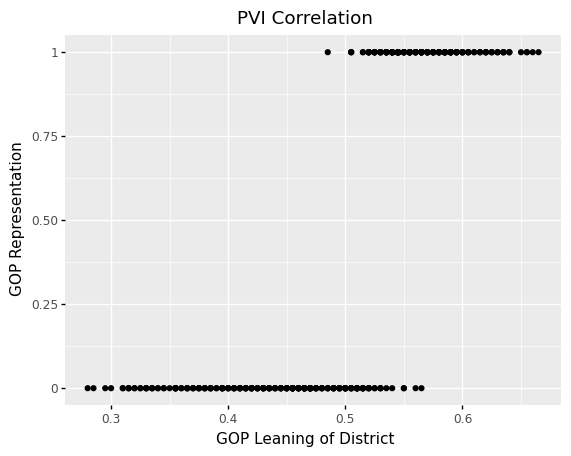

<ggplot: (8794392915938)>

In [13]:
# Create a super simple scatterplot to examine the relationship between PVI and congressional district
(p9.ggplot(data=pure_116, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y='GOP Representation',color="",title="PVI Correlation"))

Here we see a heavy democratic leaning, with a some seats even beyond R+10 being occupied by Democrats

In [14]:
#group by metric and average GOP seats
bm_116 = pure_116.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_116 = bm_116.reset_index()

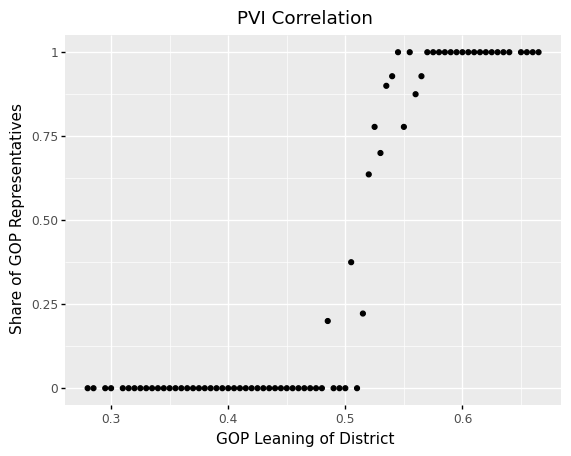

<ggplot: (8794392923727)>

In [15]:
#Plot averages
(p9.ggplot(data=bm_116, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

This too shows the heavy power of a Democratic wave, with PVIs with a Republican lean are still scroing 100% Democratic

In [16]:
#now lets limit the data to only the R+10 to D+10 range, calling it Limited Domain
ld_116 = bm_116[bm_116["metric"] <= .55]
ld_116 = ld_116[ld_116["metric"] >= .45]

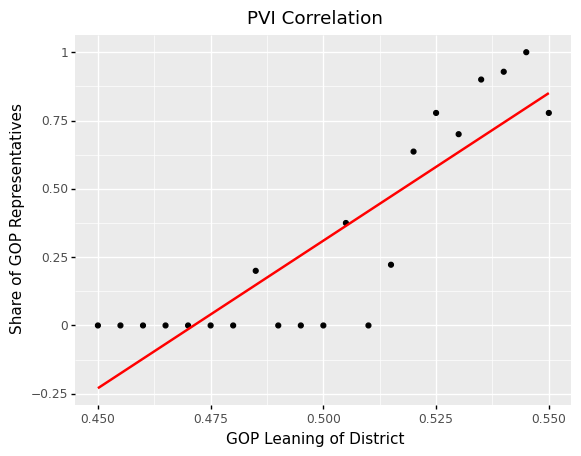

<ggplot: (8794393343808)>

In [17]:
#Plot averages
(p9.ggplot(data=ld_116, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + geom_smooth(method = "lm", color = "red", se = False)
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))